In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import glob

In [21]:
%pip install global_land_mask

     |████████████████████████████████| 1.8 MB 2.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
from global_land_mask import globe

In [2]:
models = ["AWI-CM-1-1-MR",
"AWI-ESM-1-1-LR",
"BCC-CSM2-MR",
"BCC-ESM1",
"CAMS-CSM1-0",
"CAS-ESM2-0",
"CIESM",
"CMCC-ESM2",
"CanESM5-1",
"E3SM-1-1",
"E3SM-1-1-ECA",
"E3SM-2-0",
"EC-Earth3-Veg-LR",
"FIO-ESM-2-0",
"GFDL-ESM4",
"GISS-E2-2-H",
"ICON-ESM-LR",
"IPSL-CM5A2-INCA",
"IPSL-CM6A-LR-INCA",
"KIOST-ESM",
"MCM-UA-1-0",
"NorESM2-MM",
    "ACCESS-CM2",
    "ACCESS-ESM1-5",
    "CanESM5",
    "CESM-FV2",
    "CESM2",
    "CESM2-WACCM",
    "CESM2-WACCM-FV2",
    "CMCC-CM2-HR4",
    "CMCC-CM2-SR5",
    "CNRM-CM6-1-HR",
    "CNRM-CM6-1",
    "E3SM-1-0",
    "EC-Earth3-AerChem",
    "EC-Earth3-CC",
    "EC-Earth3-Veg",
    "EC-Earth3",
    "FGOALS-f3-L",
    "FGOALS-g3",
    "GFDL-CM4",
    "GISS-E2-1-G",
    "GISS-E2-2-G",
    "GISS-E2-1-H",
    "HadGEM3-GC31-LL",
    "HadGEM3-GC31-MM",
    "IITM-ESM",
    "INM-CM4-8",
    "INM-CM5-0",
    "IPSL-CM6A-LR",
    "KACE-1-0-G",
    "MIROC6",
    "MIROC-ES2L",
    "MPI-ESM-1-2-HAM",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
    "MRI-ESM2-0",
    "NESM3",
    "NorCPM1",
    "NorESM2-LM",
    "SAM0-UNICON",
    "TaiESM1",
    "UKESM1-0-LL"
]

In [99]:
def open_sst(file):

    final_times = pd.date_range('1980-01-01', '2014-12-31', freq='1M')
    
    final_lat = np.arange(-90, 91, 1)
    final_lon = np.arange(-180, 180, 1)
    
    sst_ds = xr.open_mfdataset(file).ts
    
    #Need to convert the longitude coordinate
    new_lons = ((sst_ds.lon + 180) % 360) - 180

    sst_ds['lon'] = new_lons

    sst_ds = sst_ds.sortby('lon')
    
    lon_grid, lat_grid = np.meshgrid(sst_ds.lon.values, sst_ds.lat.values)

    globe_land_mask = globe.is_land(lat_grid, lon_grid)
    
    sst_ds = sst_ds.where(~globe_land_mask)
    
    sst_ds = sst_ds.sel(time=slice('1980-01-01','2014-12-31'))

    sst_ds = sst_ds.interp(lat=final_lat).interp(lon=final_lon)
    
    sst_ds['time'] = final_times
    
    sst_ds = sst_ds.compute()
    
    return sst_ds

In [100]:
sst_historical_data = []
sst_historical_names = []
for model in models:
    try:   
        file_name = f'../CMIP6/data/s_{model}_e_historical_vl_r1i1p1f1_f_mon_r_atmos_v_ts/*Amon*'
        sst_historical = open_sst(file_name)
        sst_historical_data.append(sst_historical)
        sst_historical_names.append(model)
    except:
        print('Historical: ' + model)
      

    

Historical: CIESM
Historical: EC-Earth3-Veg-LR
Historical: FIO-ESM-2-0
Historical: ICON-ESM-LR
Historical: KIOST-ESM
Historical: MCM-UA-1-0
Historical: CESM-FV2


/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Historical: CNRM-CM6-1-HR
Historical: CNRM-CM6-1
Historical: EC-Earth3-AerChem
Historical: EC-Earth3
Historical: GFDL-CM4
Historical: HadGEM3-GC31-LL
Historical: HadGEM3-GC31-MM
Historical: KACE-1-0-G
Historical: MIROC-ES2L
Historical: SAM0-UNICON
Historical: UKESM1-0-LL


In [101]:
hist_sst_ds = xr.concat(sst_historical_data,  pd.Index(sst_historical_names, name='model'))

hist_sst_ds = hist_sst_ds.compute()

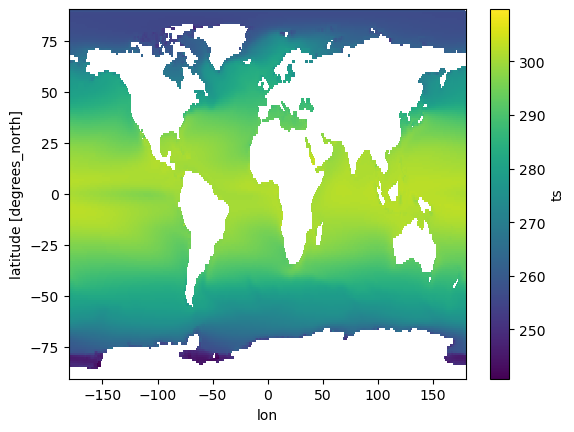

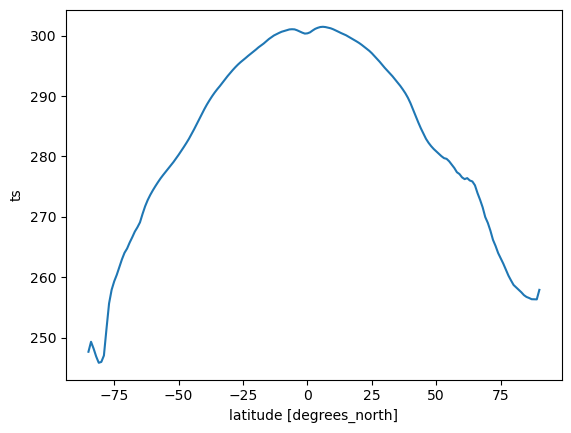

In [103]:
hist_sst_ds.mean(['time','model']).plot()

plt.show()

hist_sst_ds.mean(['time','model', 'lon']).plot()

plt.show()

In [104]:
#hist_sst_ds.to_netcdf('../AHT_trends_work/hist_sst_ds.nc')

In [94]:
amip_sst = xr.open_dataset('../amip_ssts.nc').tosbcs

#Need to convert to -180 to 180
new_lons = ((amip_sst.lon + 180) % 360) - 180

amip_sst['lon'] = new_lons

amip_sst = amip_sst.sortby('lon')

amip_sst

<xarray.DataArray 'tosbcs' (time: 1824, lat: 180, lon: 360)>
[118195200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T12:00:00 ... 2021-12-16T12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Constructed mid-month Sea Surface Temperature
    units:          degC
    cell_methods:   time: point
    cell_measures:  area: areacello

In [95]:
#amip_sst = xr.open_dataset('../amip_ssts.nc').tosbcs

lon_grid, lat_grid = np.meshgrid(amip_sst.lon.values, amip_sst.lat.values)

globe_land_mask = globe.is_land(lat_grid, lon_grid)
    
amip_sst_masked = amip_sst.where(~globe_land_mask)

amip_sst_masked += 273.15

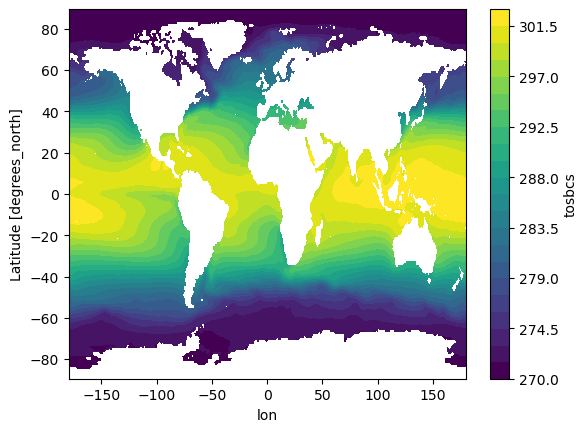

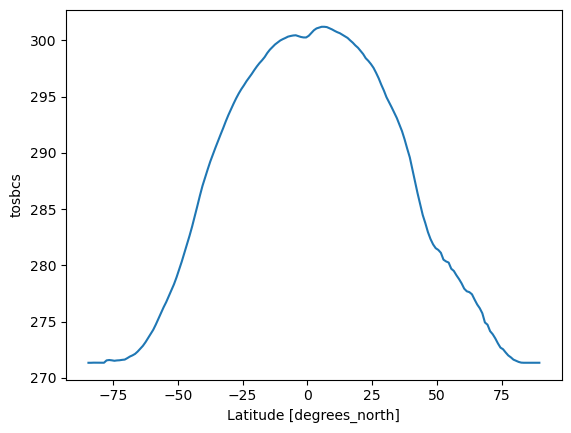

In [97]:
(amip_sst_masked.mean('time')).plot.contourf(levels=30)

plt.show()

amip_sst_masked.mean(['time','lon'], skipna=True).plot()
plt.show()

In [98]:
#amip_sst_masked.to_netcdf('amip_sst.nc')

In [67]:
ersst = xr.open_dataset('../ersstv5.nc').sst

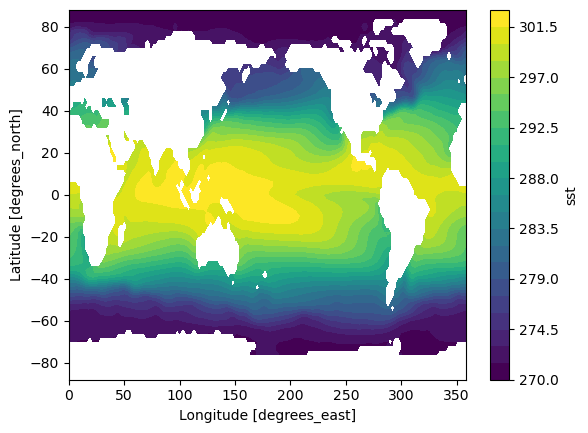

In [71]:
(273.15 + ersst.mean('time')).plot.contourf(levels=30)

plt.show()